In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100
FILE_PATH = "/content/drive/MyDrive/FYP/DATA_SET(Pea_Plant_Quality_Assesment)"

In [ ]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=FILE_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

class_names = dataset.class_names

Found 1464 files belonging to 4 classes.


In [ ]:
# Split the dataset into train, test, and validation sets
def get_dataset_partitions(ds, train_split=0.8, test_split=0.1, valid_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + test_split + valid_split == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    valid_size = int(ds_size * valid_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds, test_ds, valid_ds

train_ds, test_ds, valid_ds = get_dataset_partitions(dataset)

In [ ]:
# Preprocess the data
rescale_and_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE)
])


In [ ]:
# Build the model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])



58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
#model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 14,747,780
Trainable params: 33,092
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS
)

Epoch 1/100
36/36 [==============================] - 627s 439ms/step - loss: 1.4474 - accuracy: 0.5778 - val_loss: 0.4987 - val_accuracy: 0.8203
Epoch 2/100
36/36 [==============================] - 13s 318ms/step - loss: 0.4415 - accuracy: 0.8514 - val_loss: 0.4327 - val_accuracy: 0.8750
Epoch 3/100
36/36 [==============================] - 13s 311ms/step - loss: 0.3081 - accuracy: 0.8951 - val_loss: 0.1691 - val_accuracy: 0.9609
Epoch 4/100
36/36 [==============================] - 11s 242ms/step - loss: 0.2124 - accuracy: 0.9344 - val_loss: 0.2404 - val_accuracy: 0.9062
Epoch 5/100
36/36 [==============================] - 11s 245ms/step - loss: 0.1753 - accuracy: 0.9458 - val_loss: 0.1876 - val_accuracy: 0.9609
Epoch 6/100
36/36 [==============================] - 11s 267ms/step - loss: 0.1677 - accuracy: 0.9537 - val_loss: 0.1187 - val_accuracy: 0.9766
Epoch 7/100
36/36 [==============================] - 12s 290ms/step - loss: 0.1323 - accuracy: 0.9642 - val_loss: 0.1586 - val_accuracy

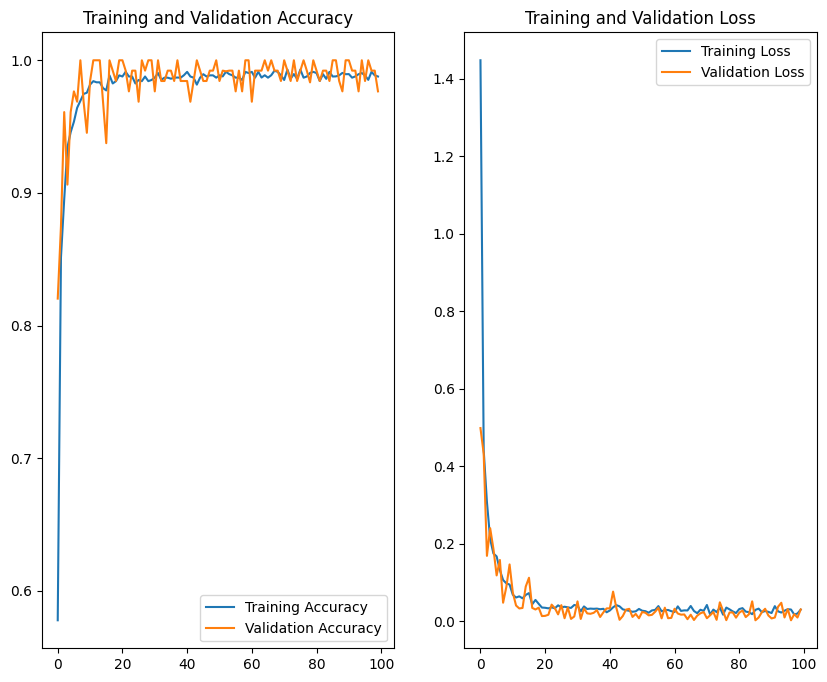

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# Evaluate the model
scores = model.evaluate(test_ds)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

6/6 [==============================] - 3s 174ms/step - loss: 0.0273 - accuracy: 0.9896
Test loss: 0.02733469009399414
Test accuracy: 0.9895833134651184


1/1 [==============================] - 0s 28ms/step


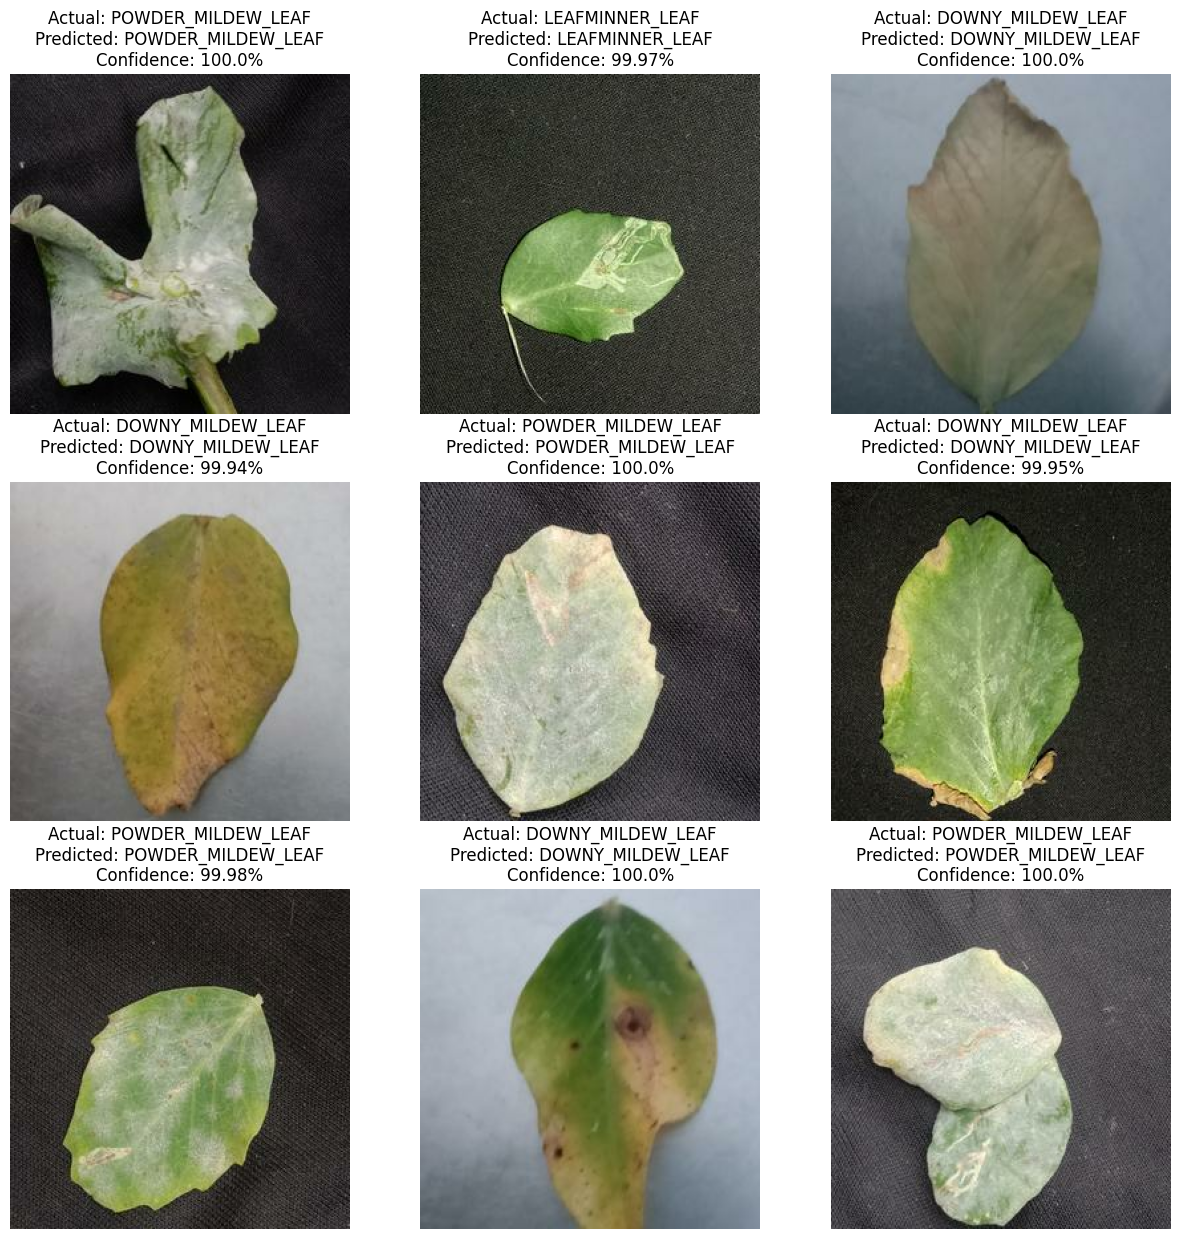

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * np.max(predictions[0]), 2)
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

plt.show()


In [ ]:
import os

# Directory path
directory = "/content/drive/MyDrive"

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Find the maximum model version
existing_models = [i for i in os.listdir(directory) if i.startswith("model_")]
model_version = max([int(i.split('_')[1]) for i in existing_models] + [0]) + 1

# Save the model
model.save(os.path.join(directory, f"model_{model_version}"))


1/1 [==============================] - 0s 42ms/step


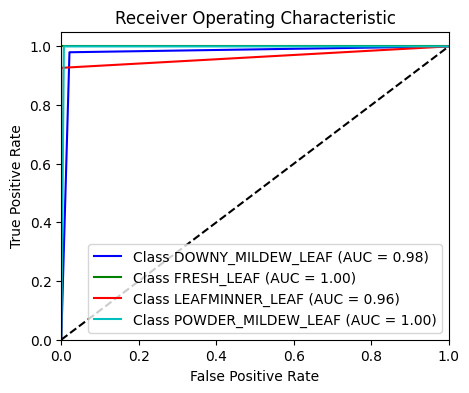

In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test dataset
y_pred_prob = model.predict(test_ds)
y_test = []
y_pred = []

# Convert the predicted probabilities and true labels into one-hot encoded format
for images, labels in test_ds:
    y_test.extend(labels)
    y_pred.extend(np.argmax(model.predict(images), axis=-1))

y_test = label_binarize(y_test, classes=range(n_classes))
y_pred_prob = label_binarize(y_pred, classes=range(n_classes))

# Compute the ROC curve and area under the curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(5, 4))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Convert the one-hot encoded labels into class indices
y_test_indices = np.argmax(y_test, axis=-1)

# Convert the predicted labels into a flat list
y_pred_flat = np.argmax(y_pred_prob, axis=-1)

# Compute precision, recall, F1 score, and support for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test_indices, y_pred_flat)

# Print the F1 score for each class
for i, class_name in enumerate(class_names):
    print(f"F1 score for {class_name}: {f1[i]}")


F1 score for DOWNY_MILDEW_LEAF: 0.9607843137254902
F1 score for FRESH_LEAF: 1.0
F1 score for LEAFMINNER_LEAF: 0.9620253164556963
F1 score for POWDER_MILDEW_LEAF: 0.9885057471264368


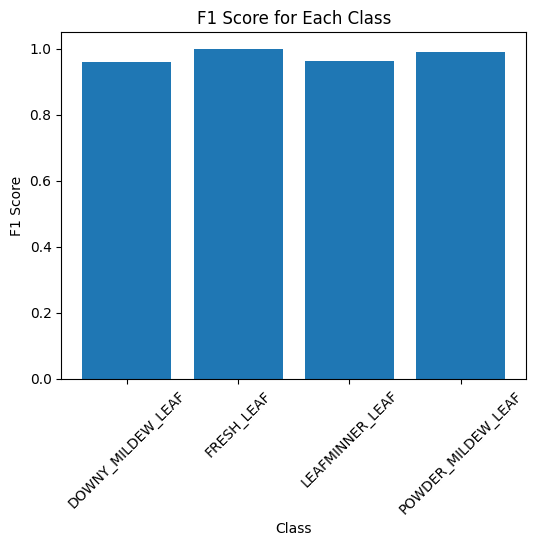

In [ ]:
import matplotlib.pyplot as plt

# Convert the one-hot encoded labels into class indices
y_test_indices = np.argmax(y_test, axis=-1)

# Convert the predicted labels into a flat list
y_pred_flat = np.argmax(y_pred_prob, axis=-1)

# Compute precision, recall, F1 score, and support for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test_indices, y_pred_flat)

# Plot the F1 score for each class
plt.figure(figsize=(6, 4.5))
plt.bar(class_names, f1)
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("F1 Score for Each Class")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Evaluate model performance on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

# Print the test loss and accuracy
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

6/6 [==============================] - 5s 184ms/step - loss: 0.0216 - accuracy: 0.9844
Test Loss: 0.02155476063489914
Test Accuracy: 0.984375


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert the true and predicted labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)

1/1 [==============================] - 0s 30ms/step
                    precision    recall  f1-score   support

 DOWNY_MILDEW_LEAF       0.98      1.00      0.99        49
        FRESH_LEAF       1.00      1.00      1.00        53
   LEAFMINNER_LEAF       1.00      0.98      0.99        45
POWDER_MILDEW_LEAF       1.00      1.00      1.00        45

          accuracy                           0.99       192
         macro avg       0.99      0.99      0.99       192
      weighted avg       0.99      0.99      0.99       192

